### Group 32: Saghar Alvandi, Sahar Abedi
### Hours spent on the task: Saghar 18h, Sahar 18h

# DAT405/DIT407 Introduction to Data Science and AI 
## 2022-2023, Reading Period 4
## Assignment 4: Spam classification using Naïve Bayes 
The exercise takes place in this notebook environment.
Hints:
You can execute certain linux shell commands by prefixing the command with `!`. You can insert Markdown cells and code cells. The first you can use for documenting and explaining your results the second you can use writing code snippets that execute the tasks required.  

In this assignment you will implement a Naïve Bayes classifier in Python that will classify emails into spam and non-spam (“ham”) classes.  Your program should be able to train on a given set of spam and “ham” datasets. 
You will work with the datasets available at https://spamassassin.apache.org/old/publiccorpus/. There are three types of files in this location: 
-	easy-ham: non-spam messages typically quite easy to differentiate from spam messages. 
-	hard-ham: non-spam messages more difficult to differentiate 
-	spam: spam messages 

**Execute the cell below to download and extract the data into the environment of the notebook -- it will take a few seconds.** If you chose to use Jupyter notebooks you will have to run the commands in the cell below on your local computer, with Windows you can use 
7zip (https://www.7-zip.org/download.html) to decompress the data.

**What to submit:** 
Convert the notebook to a pdf-file and submit it. Make sure all cells are executed so all your code and its results are included. Double check the pdf displays correctly before you submit it.

In [1]:
#Download and extract data
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2
!tar -xjf 20021010_easy_ham.tar.bz2
!tar -xjf 20021010_hard_ham.tar.bz2
!tar -xjf 20021010_spam.tar.bz2

--2023-04-25 10:14:29--  https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 2a04:4e42::644, 151.101.2.132
Connecting to spamassassin.apache.org (spamassassin.apache.org)|2a04:4e42::644|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1677144 (1.6M) [application/x-bzip2]
Saving to: '20021010_easy_ham.tar.bz2.9'

     0K .......... .......... .......... .......... ..........  3% 2.31M 1s
    50K .......... .......... .......... .......... ..........  6%  555K 2s
   100K .......... .......... .......... .......... ..........  9% 2.53M 1s
   150K .......... .......... .......... .......... .......... 12% 1.58M 1s
   200K .......... .......... .......... .......... .......... 15% 1.57M 1s
   250K .......... .......... .......... .......... .......... 18%  427K 1s
   300K .......... .......... .......... .......... .......... 21% 4.44M 1s
   350K .......... .......... .......... ..

*The* data is now in the three folders `easy_ham`, `hard_ham`, and `spam`.

In [2]:
!ls -lah

'ls' is not recognized as an internal or external command,
operable program or batch file.


### 1. Preprocessing: 

##### 1.1 Look at a few emails from easy_ham, hard_ham and spam. Do you think you would be able to classify the emails just by inspection? How do you think a succesful model can learn the difference between the different classes of emails?


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pathlib
import email
import email.policy
import os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display_html 
from email import message_from_string


#Method which saves files of a directory to a dataframe
def getFiles(folderpath):
    filepaths = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
    df = pd.DataFrame(filepaths, columns=["FilePath"])
    return df

#Method which extract all messages from a dataframe containing file-paths
def getFileContent(dataFrame, is_spam):
    messages = []
    for i in range(len(dataFrame)):
        filename = dataFrame.iloc[i,0]
        with open(filename, encoding="Latin-1") as f:
            messages.append([f.read(), is_spam]) #The "is_spam" indicates whether it is spam (1) or ham (0)
    data = pd.DataFrame(messages, columns=["Content","Type"])
    return data

#Assigning file contents from directory to respective data frames
easy_ham_files = getFiles('easy_ham')
hard_ham_files = getFiles('hard_ham')
spam_files = getFiles('spam')

#Extract content from the file paths
easy_ham_content = getFileContent(easy_ham_files, 0)
hard_ham_content = getFileContent(hard_ham_files, 0)
spam_content = getFileContent(spam_files, 1)

# Print the number of emails in each class and a sample of 10 rows from each data frame
print('Easy ham:', len(easy_ham_content))
print('Hard ham:', len(hard_ham_content))
print('Spam:', len(spam_content))
print('\nSample of 10 rows from Easy Ham:')
print(easy_ham_content.sample(10))
print('\nSample of 10 rows from Hard Ham:')
print(hard_ham_content.sample(10))
print('\nSample of 10 rows from Spam:')
print(spam_content.sample(10))

Easy ham: 2551
Hard ham: 250
Spam: 501

Sample of 10 rows from Easy Ham:
                                                Content  Type
2226  From rssfeeds@jmason.org  Tue Oct  1 10:37:01 ...     0
1098  From exmh-users-admin@redhat.com  Fri Sep 13 1...     0
305   From ilug-admin@linux.ie  Fri Sep  6 11:40:51 ...     0
1176  From rpm-list-admin@freshrpms.net  Mon Sep  9 ...     0
1389  From rpm-list-admin@freshrpms.net  Wed Aug 28 ...     0
1247  From exmh-users-admin@redhat.com  Fri Aug 23 1...     0
2139  From rssfeeds@jmason.org  Fri Sep 27 10:41:41 ...     0
1001  From spamassassin-talk-admin@lists.sourceforge...     0
2325  From rssfeeds@jmason.org  Thu Oct  3 12:24:52 ...     0
764   From fork-admin@xent.com  Sun Sep 22 21:57:45 ...     0

Sample of 10 rows from Hard Ham:
                                               Content  Type
76   Return-Path: <bounce-lghtml-2534368@sprocket.l...     0
163  From noreply@sourceforge.net  Wed Aug 14 17:36...     0
236  From champion@handango.

Answer 1.1:

It would be difficult to classify emails just by inspection, as spam emails are often designed to look like legitimate emails.
A successful model can learn the difference between the different classes of emails by using machine learning algorithms that can analyze the content, format, and other characteristics of emails. These algorithms can identify patterns and features of each class of emails, and use these to make predictions about the class of new emails. For example, the model might learn that spam emails mostly have certain keywords or phrases in the subject or body, or that they often come from certain email addresses or domains. By analyzing these features, the model can learn to differentiate between various classes of emails with high accuracy.

##### 1.2 Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text (in the optional part further down can experiment with filtering out the headers and footers). We don’t want to train and test on the same data (it might help to reflect on why if you don't recall). Split the spam and the ham datasets in a training set and a test set. (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`). Use only the easy_ham part as ham data for quesions 1 and 2.

In [14]:
# Split easy_ham_content into train and test sets
easy_ham_train, easy_ham_test = train_test_split(easy_ham_content, test_size=0.2, random_state=42)

# Split spam_content into train and test sets
spam_train, spam_test = train_test_split(spam_content, test_size=0.2, random_state=42)

# Filter the ham_train and ham_test from easy_ham_train and easy_ham_test respectively
ham_train = easy_ham_train[easy_ham_train['Type'] == 0]
ham_test = easy_ham_test[easy_ham_test['Type'] == 0]

# Print the size of the resulting data frames
print('Size of ham train:', len(ham_train))
print('Size of ham test:', len(ham_test))
print('Size of spam train:', len(spam_train))
print('Size of spam test:', len(spam_test))


Size of ham train: 2040
Size of ham test: 511
Size of spam train: 400
Size of spam test: 101


### 2.1 Write a Python program that: 
1.	Uses the four datasets from Question 1 (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`) 
2.	Trains a Naïve Bayes classifier (use the [scikit-learn library](https://scikit-learn.org/stable/)) on `hamtrain` and `spamtrain`, that classifies the test sets and reports True Positive and False Negative rates on the `hamtest` and `spamtest` datasets. Use `CountVectorizer` ([Documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)) to transform the email texts into vectors. Please note that there are different types of Naïve Bayes Classifier in scikit-learn ([Documentation here](https://scikit-learn.org/stable/modules/naive_bayes.html)). Test two of these classifiers that are well suited for this problem:
- Multinomial Naive Bayes  
- Bernoulli Naive Bayes. 

Please inspect the documentation to ensure input to the classifiers is appropriate before you start coding. 



In [21]:
def bayesClassifier(hamTrain, spamTrain, hamTest, spamTest):  
    #Setting up parameters for classifer
    x_train = pd.concat([hamTrain["Content"], spamTrain["Content"]])
    y_train = pd.concat([hamTrain["Type"], spamTrain["Type"]])
    x_test = pd.concat([hamTest["Content"], spamTest["Content"]])
    y_test = pd.concat([hamTest["Type"], spamTest["Type"]])
    
    #Convert a collection of text documents to a matrix of token counts.
    #Needed in order to convert string to float for fitting 
    vectorizer = CountVectorizer()
    vectorizer.fit(x_train) #Learn a vocabulary dictionary
    trainVector = vectorizer.transform(x_train) #encode document as a vector
    testVector = vectorizer.transform(x_test) #encode document as a vector
    
    # Create classifiers
    clf_MNB = MultinomialNB() # Multinomial Naive Bayes
    clf_BNB = BernoulliNB(fit_prior=False, binarize=1) # Bernouilli Naive Bayes

    #Model fitting 
    clf_MNB.fit(trainVector, y_train) 
    clf_BNB.fit(trainVector, y_train) 
    
    #Perform classification on array of test vectors
    y_pred_MNB = clf_MNB.predict(testVector) 
    y_pred_BNB = clf_BNB.predict(testVector)

    # Confusion matrix
    confusionMatrixMNB = metrics.confusion_matrix(y_test, y_pred_MNB)
    confusionMatrixBNB = metrics.confusion_matrix(y_test, y_pred_BNB)

    # Create figure with Seaborn
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9, wspace=0.4, hspace=0.4)
    sns.heatmap(confusionMatrixMNB, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r', ax=axs[0])
    axs[0].set_xlabel('Predicted') 
    axs[0].set_ylabel('Actual') 
    sns.heatmap(confusionMatrixBNB, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r', ax=axs[1])
    axs[1].set_xlabel('Predicted') 
    axs[1].set_ylabel('Actual') 
    
    axs[0].set_title('Fig: ' + str(getFigureNmr()) + ' Accuracy Score Multinomial Naive Bayes: {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_MNB)*100), size = 12); #set title
    axs[1].set_title('Fig: ' + str(getFigureNmr()) + ' Accuracy Score Bernouilli Naive Bayes: {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_BNB)*100), size = 12); #set title
    
    
bayesClassifier(easyHamTrain, spamTrain, easyHamTest, spamTest)   

NameError: name 'easyHamTrain' is not defined

### 2.2 Answer the following questions:
##### a) What does the CountVectorizer do?

CountVectorizer is a tool used in natural language processing to convert text into numbers that can be understood by computers and machine learning algorithms. CountVectorizer is commonly used in text classification tasks such as sentiment analysis, spam filtering, and topic modeling.
It does this by counting how many times each word appears in the text (tokenizing) for example by breaking it down into individual words or terms and then counting the frequency of each word or term. The output of CountVectorizer is a matrix, where each row represents a document or text sample, and each column represents a unique word or term from the text. The values in the matrix are the counts of how many times each word or term appears in the corresponding document.

##### b) What is the difference between Multinomial Naive Bayes and Bernoulli Naive Bayes

Multinomial Naive Bayes and Bernoulli Naive Bayes are two variants of the Naive Bayes algorithm used for text classification and document analysis. The difference between them is in how they look at the words in the text. Multinomial Naive Bayes counts how often each word appears, while Bernoulli Naive Bayes just checks if a word appears at all. Multinomial Naive Bayes works well when the frequency of words matters, while Bernoulli Naive Bayes works well when we only care if a word appears or not. Both methods have some similarities and differences, but they are based on the same idea.


### 3.1 Run the two models:
Run (don't retrain) the two models from Question 2 on spam versus hard-ham. Does the performance differ compared to question 2 when the model was run on spam versus easy-ham? If so, why?

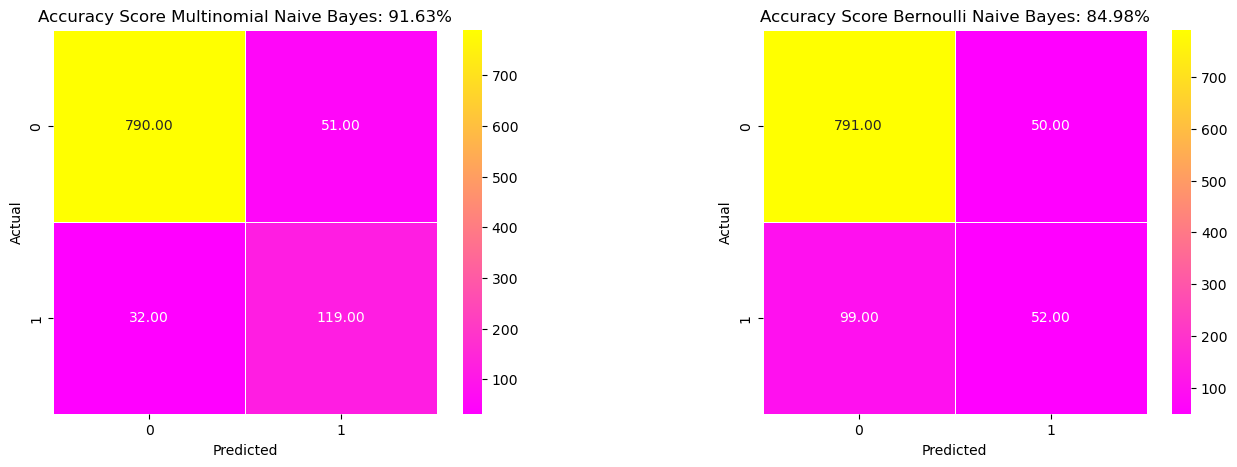

In [173]:
def bayesClassifier(easyHamTrain, spamTrain, easyHamTest, spamTest, hardHamTest):
    # Setting up parameters for classifier
    x_train = pd.concat([easyHamTrain["Content"], spamTrain["Content"]])
    y_train = pd.concat([easyHamTrain["Type"], spamTrain["Type"]])
    x_test = pd.concat([easyHamTest["Content"], spamTest["Content"], hardHamTest["Content"]])
    y_test = pd.concat([easyHamTest["Type"], spamTest["Type"], hardHamTest["Type"]])
    
    # Convert a collection of text documents to a matrix of token counts.
    # Needed in order to convert string to float for fitting 
    vectorizer = CountVectorizer()
    vectorizer.fit(x_train) # Learn a vocabulary dictionary
    trainVector = vectorizer.transform(x_train) # encode document as a vector
    testVector = vectorizer.transform(x_test) # encode document as a vector
    
    # Create classifiers
    clf_MNB = MultinomialNB() # Multinomial Naive Bayes
    clf_BNB = BernoulliNB(fit_prior=False, binarize=1) # Bernoulli Naive Bayes

    # Model fitting 
    clf_MNB.fit(trainVector, y_train) 
    clf_BNB.fit(trainVector, y_train) 
    
    # Perform classification on array of test vectors
    y_pred_MNB = clf_MNB.predict(testVector) 
    y_pred_BNB = clf_BNB.predict(testVector)

    # Confusion matrix
    confusionMatrixMNB = metrics.confusion_matrix(y_test, y_pred_MNB)
    confusionMatrixBNB = metrics.confusion_matrix(y_test, y_pred_BNB)

    # Create figure with Seaborn
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9, wspace=0.4, hspace=0.4)
    sns.heatmap(confusionMatrixMNB, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='spring', ax=axs[0])
    axs[0].set_xlabel('Predicted') 
    axs[0].set_ylabel('Actual') 
    sns.heatmap(confusionMatrixBNB, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='spring', ax=axs[1])
    axs[1].set_xlabel('Predicted') 
    axs[1].set_ylabel('Actual') 
    
    axs[0].set_title('Accuracy Score Multinomial Naive Bayes: {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_MNB)*100), size=12); # set title
    axs[1].set_title('Accuracy Score Bernoulli Naive Bayes: {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_BNB)*100), size=12); # set title

bayesClassifier(easyHamTrain, spamTrain, easyHamTest, spamTest, hardHamTest)


The performance differs compared to question 2 when the model was run on spam versus "easy-ham" and we can see that the accuracy has been slightly decreased compared to the previous question. This is because the "hard_ham" dataset may contain emails with different characteristics than the "easy_ham" dataset. For example differences in the types of emails; the "hard-ham" dataset may contain emails that are more similar in content to spam emails than the "easy-ham" dataset. This could make it harder for the models to accurately classify emails as spam or ham. So the model may not be able to generalize well to these new email types, resulting in lower performance.

However, the difference in performance is not significant. The performance depends on how similar the "hard_ham" emails are to the emails in the "easy_ham" dataset. If they are similar, the performance may not be affected much. If they are very different, the performance may be significantly worse.


### 3.2 Retrain
Retrain new Multinomial and Bernolli Naive Bayes classifers on the combined (easy+hard) ham and spam. Now evaluate on spam versus hard-ham as in 3.1. Also evaluate on spam versus easy-ham. Compare the performance with question 2 and 3.1. What do you observe?

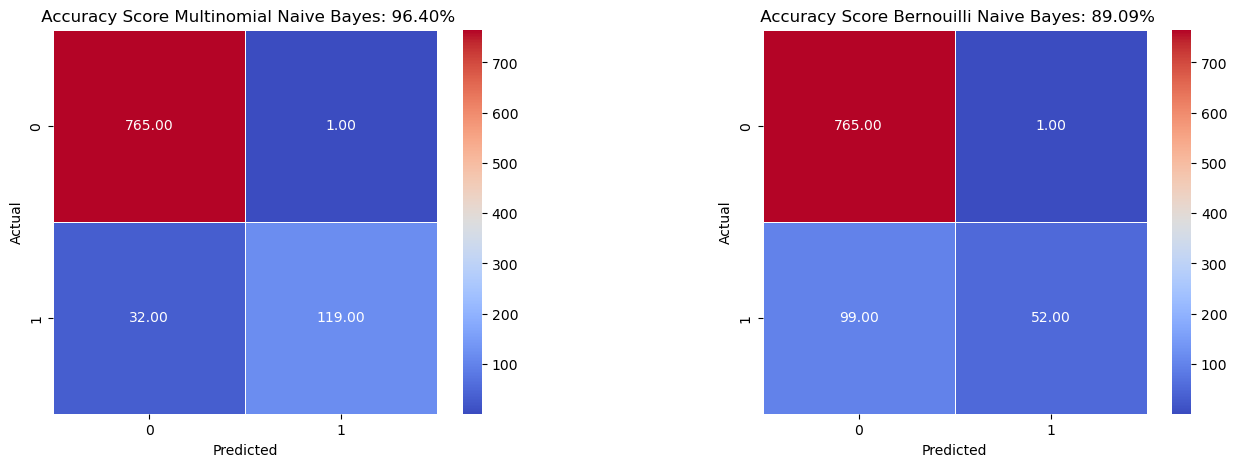

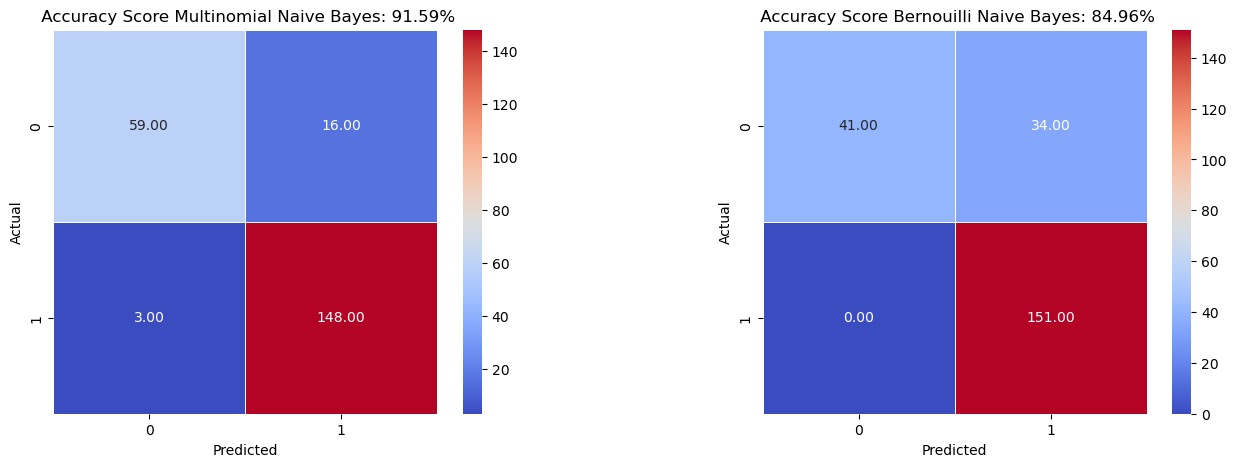

In [175]:
#Assign dataframes to variables
e_ham_files = getFiles('easy_ham')
h_ham_files = getFiles('hard_ham') 
spam_ham_files = getFiles('spam')

#Assigning file contents from directory to respective data frames
easyHamContent = getFileContent(e_ham_files,0)
hardHamContent = getFileContent(h_ham_files,0)
spamContent = getFileContent(spam_ham_files,1)

# Combine easy_ham and hard_ham data frames
hamContent = pd.concat([easyHamContent, hardHamContent], ignore_index=True)

# Split data frames into training set and test set (70-30)
hamTrain, hamTest = train_test_split(hamContent, test_size=0.3, random_state=0)
spamTrain, spamTest = train_test_split(spamContent, test_size=0.3, random_state=0)


def bayesClassifier(hamTrain, spamTrain, hamTest, spamTest):  
    #Setting up parameters for classifer
    x_train = pd.concat([hamTrain["Content"], spamTrain["Content"]])
    y_train = pd.concat([hamTrain["Type"], spamTrain["Type"]])
    x_test = pd.concat([hamTest["Content"], spamTest["Content"]])
    y_test = pd.concat([hamTest["Type"], spamTest["Type"]])
    
    #Convert a collection of text documents to a matrix of token counts.
    #Needed in order to convert string to float for fitting 
    vectorizer = CountVectorizer()
    vectorizer.fit(x_train) #Learn a vocabulary dictionary
    trainVector = vectorizer.transform(x_train) #encode document as a vector
    testVector = vectorizer.transform(x_test) #encode document as a vector
    
    # Create classifiers
    clf_MNB = MultinomialNB() # Multinomial Naive Bayes
    clf_BNB = BernoulliNB(fit_prior=False, binarize=1) # Bernouilli Naive Bayes

    #Model fitting 
    clf_MNB.fit(trainVector, y_train) 
    clf_BNB.fit(trainVector, y_train) 
    
    #Perform classification on array of test vectors
    y_pred_MNB = clf_MNB.predict(testVector) 
    y_pred_BNB = clf_BNB.predict(testVector)

    # Confusion matrix
    confusionMatrixMNB = metrics.confusion_matrix(y_test, y_pred_MNB)
    confusionMatrixBNB = metrics.confusion_matrix(y_test, y_pred_BNB)

    # Create figure with Seaborn
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9, wspace=0.4, hspace=0.4)
    sns.heatmap(confusionMatrixMNB, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'coolwarm', ax=axs[0])
    axs[0].set_xlabel('Predicted') 
    axs[0].set_ylabel('Actual') 
    sns.heatmap(confusionMatrixBNB, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'coolwarm', ax=axs[1])
    axs[1].set_xlabel('Predicted') 
    axs[1].set_ylabel('Actual') 
    
    axs[0].set_title(' Accuracy Score Multinomial Naive Bayes: {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_MNB)*100), size = 12); #set title
    axs[1].set_title(' Accuracy Score Bernouilli Naive Bayes: {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_BNB)*100), size = 12); #set title
    

# Run the two models for retrained data

bayesClassifier(easyHamTrain, spamTrain, easyHamTest, spamTest)
bayesClassifier(hardHamTrain, spamTrain, hardHamTest, spamTest)

Answer 3.2:

### 3.3 Further improvements
Do you have any suggestions for how performance could be further improved? You don't have to implement them, just present your ideas.

One way to improve the performance could be instead of using the text of the emails directly as features, we could extract additional features like the length of the email, the number of capital letters, the presence of certain keywords or phrases, etc. This could potentially improve the performance of the model.

Another suggestion is that We could use more than one model to make better predictions. For example, we could train several Naive Bayes classifiers with different settings or use different classification algorithms, and then combine their predictions to get a better overall result.